### Copy of `100_SanityCheckMNIST` ipynb: Extend number of figures for experiment

In [1]:
%matplotlib inline
import os
import cv2
import glob
import math
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from scipy.stats import mode

In [4]:
import plotly
import plotly.express as px
import plotly.graph_objects as go

In [2]:
# import MINST from tesnorflow
from tensorflow.examples.tutorials.mnist import input_data

In [3]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [5]:
imgs = mnist.test.images
labels = mnist.test.labels
imgs.shape, labels.shape

((10000, 784), (10000,))

#### Get index list for each dataset
Get one index at radom for each digit-class

In [27]:
digit_index_list = []
for i in range(10):
    tmp_indices = np.where(labels == i)[0] # get as a list
    tmp_index = tmp_indices[np.random.randint(0, len(tmp_indices),1)] 
    digit_index_list.append(tmp_index)
digit_index_list  # SHOW for metadata

[array([7129]),
 array([9241]),
 array([5772]),
 array([1519]),
 array([6]),
 array([3171]),
 array([50]),
 array([8173]),
 array([6457]),
 array([3857])]

##### Select one image / each digit class

In [28]:
tmp_simgs_list = []
for i in digit_index_list:
    tmp_simgs_list.append(imgs[i].reshape(1,28,28))
simgs = np.concatenate(tmp_simgs_list,axis=0)

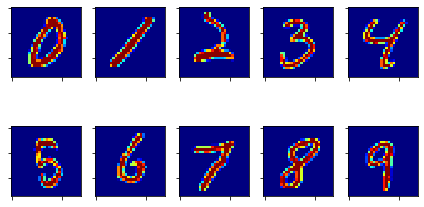

In [29]:
fig = plt.figure()
for i in range(10):
    idx = i+1
    ax = plt.subplot(2,5,idx)
    ax.imshow(simgs[i], cmap='jet')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
fig.tight_layout()
plt.show()

In [30]:
test_imgs = simgs[np.array([0,1,4,5,7,9])]

#### Replicate each digit class N times and then rotate each at random
N = 360 (0-359 degree) for second sanity check

In [31]:
def rotate_fn(images, angles):
    """
    images : 4d tensor [batch, height, width channel]
      original oprion - nearest. Additional: biilnear
    """
    rotated_tensor_images = tf.contrib.image.transform(
      images,
      tf.contrib.image.angles_to_projective_transforms(
        angles, tf.cast(tf.shape(images)[1], tf.float32), 
            tf.cast(tf.shape(images)[2], tf.float32)
        ),
    )
     #interpolation='BILINEAR'
    return rotated_tensor_images

In [32]:
def _copy_fn(spatches, height=None, width=None, ch=1,copy_size=10):
    img_list = []
    for patch in spatches:
        img_list.extend([np.reshape(patch, (1,height,width,ch))])
        img_list.extend([ np.expand_dims(np.copy(patch.reshape(height,width,ch)), axis=0) 
                     for i in range(copy_size-1)])
    imgs = np.concatenate(img_list, axis=0)
    print(imgs.shape)
    return imgs

In [35]:
def copy_rotate_fn(oimgs, height=None, width=None, channel=1, copy_size=10, nclusters=6):
    _,h,w = oimgs.shape
    imgs= _copy_fn(oimgs,height=h, width=w,ch=channel,copy_size=copy_size)
    # rotate
    #radians = [i*math.pi/180 for i in np.random.randint(0,360, len(imgs))]
    #random.sample(range(1, 100), 3)
    #X = random.sample(range(0,360),len(imgs))
    
    # deterministically orient 
    X = [i for i in range(0,360,1)] * nclusters
    radians =  [i*math.pi/180 for i in X]
    
    rimgs_tf = rotate_fn(imgs, angles=radians)
    rimgs_tf = tf.image.resize_images(rimgs_tf, (height, width))
    rtest_imgs = tf.keras.backend.eval(rimgs_tf)
    return rtest_imgs, X

##### Get replicate and rotate imgs

In [36]:
### configration
copy_size=360
height=width=128

In [37]:
rimgs, rotate_angles = copy_rotate_fn(test_imgs, height=height, width=width, 
                                      channel=1, copy_size=copy_size,nclusters=6)

(2160, 28, 28, 1)


##### Save image per file

In [38]:
savedir = './mnist_figs_N360'

In [39]:
def save_fn(imgs, sdir='./', figsize=(4,4), dpi=100):
    _imgs = np.squeeze(imgs)
    os.makedirs(sdir, exist_ok=True)
    #rcParams["savefig.format"] = 'jpg'
    for i in range(imgs.shape[0]):
        fig = plt.figure(figsize=figsize, dpi=dpi)
        ax = plt.subplot(1,1,1)
        ax.imshow(rimgs[i, :,:,0], cmap='gist_gray')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_axis_off()
        plt.savefig(os.path.join(sdir, f'img_{i}.jpg'))
        plt.close()

In [40]:
save_fn(rimgs, savedir)

###### Make sure if the image is fine or not

In [41]:
flist = glob.glob(os.path.join(savedir, '*.jpg'))

In [42]:
image = Image.open(flist[0])
image.size

(400, 400)

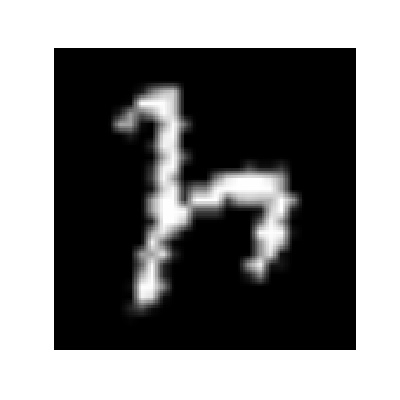

In [43]:
image

### Import saved data

In [44]:
save_dir = '/home/tkurihana/Paxis/sanity/mnist_figs_N360'

In [45]:
imgs_list = []
for i in range(rimgs.shape[0]):
    _tmp =np.expand_dims(
        np.asarray(Image.open(os.path.join(save_dir, f'img_{i}.jpg')).convert('L')),
        axis=0 
    )
    imgs_list.append(_tmp)
rimgs = np.concatenate(imgs_list, axis=0)
rimgs.shape

(2160, 400, 400)

---------------------------------

### Ananlysis seciton

In [49]:
angle_datadir = './mnist-result/N360-2160-angle'
table_datadir = './mnist-result/N360-2160-table'

In [47]:
def txt_reader(filename):
    data = []
    with open(filename, 'r') as f:
        lines = f.read()
        for line in lines.split('\n'):
            if len(line) > 0:
                data.append(float(line.strip(' ')))
    return np.asarray(data)

In [48]:
def csv_reader(filename):
    """ .csv file --> table of , and \n files
    """
    with open(filename, 'r') as f:
        lines = f.read()
        all_list = []
        for line in lines.split('\n'):
            data =line.split(',')
            data.remove('')
            msize = np.zeros((len(data))).astype(np.complex)
            for idx,i in enumerate(data):
                if len(i) > 0:
                    j = i.replace('i','j')
                    data[idx] = complex(j)
            
            if len(data) > 0:
                all_list.append(np.expand_dims(data, axis=0))
        array = np.concatenate(all_list, axis=0)
    return array

In [50]:
angle_alist= []
table_alist = []
for i in range(2160):
    angle_alist.append(txt_reader(os.path.join(angle_datadir, f'img_{i}.txt')))
    table_alist.append(csv_reader(os.path.join(table_datadir, f'img_{i}_table.csv')))

##### Visualize original patches

In [51]:
def quiver_fn(img, orient):
    step1 = img.shape[0]/orient.shape[0]
    step2 = img.shape[1]/orient.shape[1]
    x, y = np.meshgrid(
        np.arange(step1/2,img.shape[0],step1),
        np.arange(step2/2,img.shape[1],step2),
    )
    u = -orient.real / abs(orient)
    v = -1*orient.imag / abs(orient)
    """ Must flip v, u instead of u, v for converting matlab to python system
    """
    return x,y,v, u

In [56]:
def base_plot2(imgs, orients, size=(4,3),dpi=100, titles=[],
              nrow=2, ncol=5, expname=None, linewidth=5,headlength=15,
              scale=4,width=0.01,alpha=1,headwidth=3,color='black',
              cmap='jet', nmin=0, nmax=1, nclusters=6, fontsize=12):
    fig,ax  = plt.subplots(ncol, nrow,figsize=size,dpi=dpi)
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    
    imgs_list = np.array_split(imgs, nclusters)
    ix = 0
    for icol, cluster in enumerate(range(nclusters)):
        _imgs = imgs_list[icol]
        _orients = orients[icol]
        for ii,i in enumerate(_imgs) :
            ax[ii][icol].imshow(i,
                                vmin=nmin, vmax=nmax, cmap=cmap,alpha=alpha)
            ax[ii][icol].set_xticklabels([])
            ax[ii][icol].set_yticklabels([])
            ax[ii][icol].axis('off')
            
            # quiver
            #print(_orients.shape);stop
            x,y,u,v = quiver_fn(i, _orients[ii])
            #print(x,y,u,v)
            ax[ii][icol].quiver(x,y,u,v,color=color, 
                                linewidth=linewidth,units='width',
                                scale=scale, width=width, headwidth=headwidth)
           
            ax[ii][icol].set_title(f"${int(np.median(titles[ix]) )}^\circ$", 
                                  fontsize=fontsize,y=.9)
            ix+=1
    fig.tight_layout()
    plt.show()
    plt.savefig('./mnist-with-arrows_08042020-N360.png')
    plt.close()

In [53]:
len(table_alist)

2160

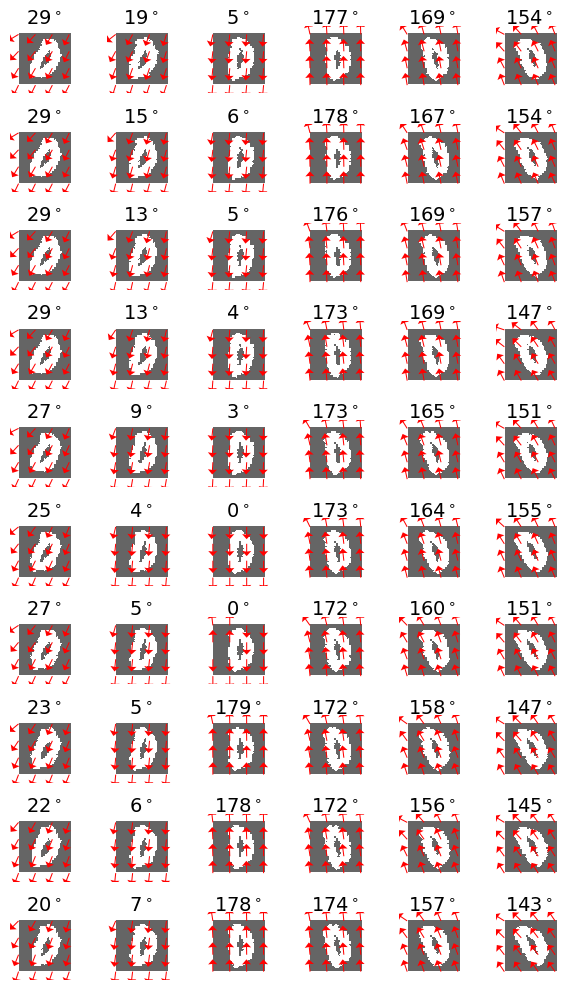

In [57]:
# RI model
N=60
# RI model
base_plot2(rimgs[:N], orients=np.array_split(table_alist[:N],6),
          size=(6,10),dpi=100, nrow=6, ncol=10, titles=angle_alist[:N],
          linewidth=8, nclusters=6,cmap='gist_gray',color='red',
          headlength=25,headwidth=9,alpha=0.6,scale=5.5, width=0.015,fontsize=14)

---------------------
#### Rose wind

In [58]:
from pylab import *
from matplotlib.colors import Colormap
def get_colors(n=-1, cmap_name='jet'):
    # colormap
    cmap = cm.get_cmap(cmap_name, n)
    colors = []
    for idx, i in enumerate(range(cmap.N)):
        rgb = cmap(i)[:3]
        #print(idx, matplotlib.colors.rgb2hex(rgb))
        colors += [matplotlib.colors.rgb2hex(rgb)]
    return colors

In [59]:
def compute_dfangle(all_list, nclusters=None,
                    topK=None, expname=None, preprocess=False, nangle=16, debug=False):
    logs_list = []
    for cluster, tmp_all_list in enumerate(all_list):
        tmp_list = [ ]
        for i in tmp_all_list:
            tmp_list.extend(i)
        # dataframe
        angles = []
        #ag = np.linspace(0,360,nangle)
        ag = np.arange(0,360,nangle)
        amax = 360+ag[1]
        for idx, i in enumerate(ag[:-1]):
            tmp = list(filter(lambda x : x  > ag[idx] and x <= ag[idx+1], tmp_list))
            angles.append(len(tmp))
        df = pd.DataFrame(np.array(angles))
        df.columns = ['frequency']
        df['theta'] = np.array([ float((i+ag[idx+1])/2) for idx, i in enumerate(ag[:-1])])
        
        logs_list.append(df)
    return logs_list

In [60]:
logs_ri_list = compute_dfangle(np.array_split(angle_alist,6), nclusters=6, nangle=1)

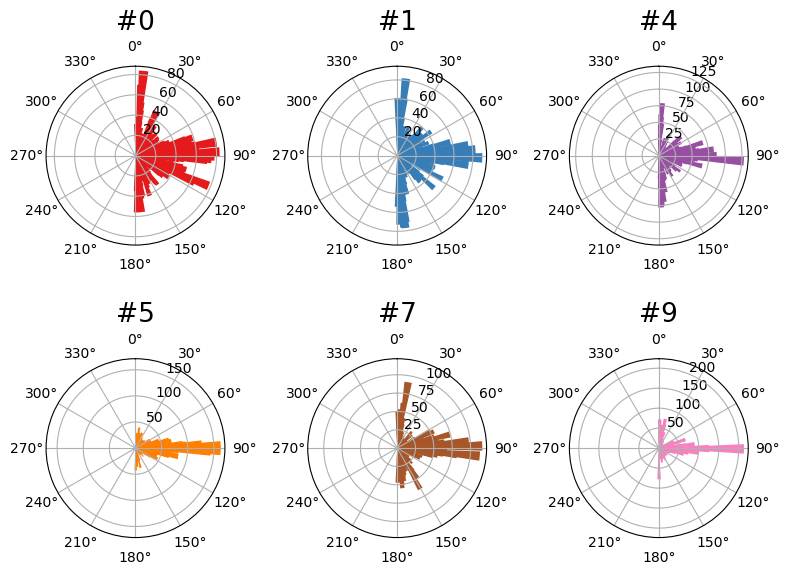

In [61]:
# Compute pie slices
nclusters = 6
cluster_list = [0,1,4,5,7,9]
mycolors =get_colors(n=nclusters+1, cmap_name='Set1')
fig = plt.figure(figsize=(8,6), dpi=100)
for cluster in range(6):
    idx = cluster + 1
    ax = plt.subplot(2,3,idx, projection='polar')
    #width = 1*(2*np.pi/28) #np.pi / 16
    width = 1*(2*np.pi/56) #np.pi / 16
    df = logs_ri_list[cluster]
    theta = df['theta'].values
    radii = df['frequency'].values
    colors = mycolors[cluster]

    #ax = plt.subplot(111, projection='polar')
    ax.bar(theta*np.pi/180, radii, width=width, bottom=0.0, color=colors, alpha=1)
    
    ax.set_title("#{}".format(cluster_list[cluster]),fontsize=19, pad=20)
    ax.set_thetagrids(range(0, 360, 30))
    ax.set_theta_zero_location('N')  # set direction of zero
    ax.set_theta_direction(-1) # set rotation as clockwise
fig.tight_layout()
plt.show()

###### Memo: Examine more difference for narrower and wider distribution clusters + visualization